In [1]:
# Olive Tree Counter for Greek Olive Groves
# Using Copernicus Sentinel-2 and Deep Learning
# Part of GeoOpen EnfTech Platform - Cassini Hackathon
"""
This notebook provides two approaches:
1. Direct counting from Sentinel-2 (10m resolution) - suitable for large groves
2. Super-resolution CNN + tree detection for smaller/denser groves

Confidence metrics help determine which approach to trust.
"""

# ============================================================================
# SECTION 1: SETUP & DEPENDENCIES
# ============================================================================

# Install required packages (run once)
# This notebook uses Copernicus APIs and local processing, not Google Earth Engine (GEE)

'\nThis notebook provides two approaches:\n1. Direct counting from Sentinel-2 (10m resolution) - suitable for large groves\n2. Super-resolution CNN + tree detection for smaller/denser groves\n\nConfidence metrics help determine which approach to trust.\n'

In [2]:

!pip install sentinelsat
!pip install rasterio
!pip install geopandas
!pip install tensorflow
!pip install opencv-python
!pip install scikit-image
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install shapely
!pip install cdse-api-client --upgrade

# Removed deprecated '!pip install sklearn' and kept only '!pip install scikit-learn'
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is 

ERROR: Could not find a version that satisfies the requirement cdse-api-client (from versions: none)
ERROR: No matching distribution found for cdse-api-client


Defaulting to user installation because normal site-packages is not writeable


In [4]:

"""
Copernicus Data Download Example (CDSE API)
Use cdse-api-client to search and download Sentinel-2 data if available.
If the package is not installed, fall back to REST API example in the next cell.
"""

# Try to import the 'cdse' client if available, otherwise set a flag and provide guidance
try:
    # cdse client (optional)
    from cdse import CDSEAPI, DataOrder, DataDownloadRequest, SearchQuery, Auth
    CDSE_AVAILABLE = True
except Exception as e:
    CDSE_AVAILABLE = False
    cdse_import_error = e
    print("cdse client not available; use the REST API cell below or install cdse-api-client if supported for your environment.")
    print("Import error:", type(e).__name__, e)

import os

# If cdse is available, provide a small helper example
if CDSE_AVAILABLE:
    # Set your CDSE credentials (replace with your own or set as environment variables)
    CDSE_USER = os.getenv('CDSE_USER', 'mpaigni@gmail.com')
    CDSE_PASS = os.getenv('CDSE_PASS', 'D1sc0rd2025!')

    # Authenticate with CDSE
    auth = Auth(username=CDSE_USER, password=CDSE_PASS)
    api = CDSEAPI(auth=auth)

    # Example AOI (bounding polygon) and time range
    aoi = {
        "type": "Polygon",
        "coordinates": [[[24.5, 35.0], [24.6, 35.0], [24.6, 35.1], [24.5, 35.1], [24.5, 35.0]]]
    }

    # Example search using cdse client
    query = SearchQuery(
        collection="SENTINEL-2",
        productType="S2MSI2A",
        aoi=aoi,
        start="2024-06-01",
        end="2024-09-30",
        cloudCover=(0, 20)
    )

    results = api.search(query)
    print(f"Found {len(results)} products via cdse client.")
    if results:
        product = results[0]
        print(f"Downloading product: {product['title']}")
        download_request = DataDownloadRequest(product_id=product['id'])
        api.download(download_request, target_dir="./cdse_downloads")
        print("Download complete via cdse client.")
    else:
        print("No products found for the given AOI and date range via cdse client.")

cdse client not available; use the REST API cell below or install cdse-api-client if supported for your environment.
Import error: ModuleNotFoundError No module named 'cdse'


In [5]:
# Download Sentinel-2 data from Copernicus Data Space Ecosystem (CDSE) using REST API and requests
import requests
import os
from requests.auth import HTTPBasicAuth

# Set your CDSE credentials (replace with your own or set as environment variables)
CDSE_USER = os.getenv('CDSE_USER', 'mpaigni@gmail.com')
CDSE_PASS = os.getenv('CDSE_PASS', 'D1sc0rd2025!')

# Define search parameters
search_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
aoi_wkt = "POLYGON((24.5 35.0, 24.6 35.0, 24.6 35.1, 24.5 35.1, 24.5 35.0))"
date_from = "2024-06-01T00:00:00.000Z"
date_to = "2024-09-30T23:59:59.999Z"
cloud_cover = "20"

# Build OData filter query
filter_query = (
    f"$filter=OData.CSC.Intersects(area=geography'SRID=4326;{aoi_wkt}') and ",
    f"ContentDate/Start ge {date_from} and ContentDate/End le {date_to} and ",
    f"CloudCover le {cloud_cover} and ProductType eq 'S2MSI2A' and PlatformName eq 'Sentinel-2'"
 )
filter_query = ''.join(filter_query)

# Search for products
response = requests.get(f"{search_url}?{filter_query}", auth=HTTPBasicAuth(CDSE_USER, CDSE_PASS))
if response.status_code == 200:
    products = response.json().get('value', [])
    print(f"Found {len(products)} products.")
    if products:
        product = products[0]
        print(f"First product title: {product['Name']}")
        # Download link (requires authentication)
        download_url = product['OnlineAccessURL']
        print(f"Download link: {download_url}")
        # Example: download the product (large files, may take time)
        # with requests.get(download_url, auth=HTTPBasicAuth(CDSE_USER, CDSE_PASS), stream=True) as r:
        #     with open(product['Name'] + '.zip', 'wb') as f:
        #         for chunk in r.iter_content(chunk_size=8192):
        #             f.write(chunk)
        # print("Download complete.")
    else:
        print("No products found for the given AOI and date range.")
else:
    print(f"Search failed: {response.status_code} {response.text}")

Search failed: 403 


In [6]:
# OliveGroveAnalyzer: Analyze olive groves using Sentinel-2 and NDVI
import numpy as np
import rasterio
import os

class OliveGroveAnalyzer:
    def __init__(self, region_bounds, start_date, end_date):
        self.region_bounds = region_bounds  # [min_lon, min_lat, max_lon, max_lat] or tuple
        self.start_date = start_date
        self.end_date = end_date
        self.tree_locations = []
        self.confidence_score = 0.0
        self.ndvi_array = None
        self.rgb_array = None

    def load_sentinel2_data(self, cloud_cover_max=20):
        # This is a placeholder for actual download logic using CDSE API
        # You should run the CDSE API cell to download the data first
        print("Sentinel-2 data should be downloaded using the CDSE API cell above.")
        print("After download, set the file paths to the B04 (red) and B08 (nir) bands.")

    def calculate_vegetation_indices(self, path_b04='path_to_B04.tif', path_b08='path_to_B08.tif'):
        # Load bands and calculate NDVI
        with rasterio.open(path_b04) as src:
            red = src.read(1).astype('float32')
        with rasterio.open(path_b08) as src:
            nir = src.read(1).astype('float32')
        self.ndvi_array = (nir - red) / (nir + red + 1e-6)
        print("NDVI calculated.")
        return self.ndvi_array

    def download_data_as_array(self, scale=10):
        # Placeholder: return file paths for NDVI and RGB (user must set these)
        ndvi_path = 'path_to_ndvi.tif'
        rgb_path = 'path_to_rgb.tif'
        print(f"Set NDVI and RGB file paths after download: {ndvi_path}, {rgb_path}")
        return ndvi_path, rgb_path

    def detect_trees_traditional(self, ndvi_array=None):
        # Simple thresholding and local maxima for tree detection (demo only)
        if ndvi_array is None:
            ndvi_array = self.ndvi_array
        if ndvi_array is None:
            raise ValueError("NDVI array not set. Run calculate_vegetation_indices first.")
        from skimage.feature import peak_local_max
        mask = ndvi_array > 0.4  # threshold for healthy vegetation
        coordinates = peak_local_max(ndvi_array, min_distance=5, threshold_abs=0.4, labels=mask)
        self.tree_locations = coordinates
        # Confidence: crude estimate based on NDVI contrast and count
        self.confidence_score = min(1.0, len(coordinates) / 1000 + 0.5)
        print(f"Detected {len(coordinates)} trees. Confidence: {self.confidence_score:.2f}")
        return coordinates, self.confidence_score

In [7]:

# ============================================================================
# SECTION 3: SUPER-RESOLUTION NEURAL NETWORK
# ============================================================================

class SuperResolutionCNN:
    """
    CNN for enhancing Sentinel-2 resolution
    Trained on high-resolution satellite/drone imagery
    """
    
    def __init__(self, scale_factor=4):
        self.scale_factor = scale_factor
        self.model = self._build_model()
    
    def _build_model(self):
        """Build ESPCN (Efficient Sub-Pixel CNN) architecture"""
        
        inputs = layers.Input(shape=(None, None, 4))  # RGBN channels
        
        # Feature extraction
        x = layers.Conv2D(64, 5, padding='same', activation='relu')(inputs)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        
        # Sub-pixel convolution for upscaling
        x = layers.Conv2D(
            4 * (self.scale_factor ** 2), 
            3, 
            padding='same'
        )(x)
        
        # Pixel shuffle
        outputs = tf.nn.depth_to_space(x, self.scale_factor)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train(self, lr_images, hr_images, epochs=50, batch_size=8):
        """
        Train the super-resolution model
        
        Parameters:
        -----------
        lr_images : numpy.ndarray
            Low resolution images (Sentinel-2)
        hr_images : numpy.ndarray
            High resolution images (drone/very high res satellite)
        """
        
        print("Training super-resolution model...")
        
        history = self.model.fit(
            lr_images,
            hr_images,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )
        
        return history
    
    def enhance_resolution(self, lr_image):
        """Apply super-resolution to low-res image"""
        
        # Add batch dimension if needed
        if len(lr_image.shape) == 3:
            lr_image = np.expand_dims(lr_image, axis=0)
        
        sr_image = self.model.predict(lr_image)
        
        return sr_image[0]

# ============================================================================
# SECTION 4: DEEP LEARNING TREE DETECTION
# ============================================================================

class TreeDetectionCNN:
    """CNN for detecting individual trees in high-resolution imagery"""
    
    def __init__(self, input_shape=(256, 256, 4)):
        self.input_shape = input_shape
        self.model = self._build_unet()
    
    def _build_unet(self):
        """Build U-Net architecture for tree crown segmentation"""
        
        inputs = layers.Input(self.input_shape)
        
        # Encoder
        c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
        c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
        p1 = layers.MaxPooling2D(2)(c1)
        
        c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
        p2 = layers.MaxPooling2D(2)(c2)
        
        c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
        p3 = layers.MaxPooling2D(2)(c3)
        
        # Bottleneck
        c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
        
        # Decoder
        u5 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
        u5 = layers.concatenate([u5, c3])
        c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u5)
        c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
        
        u6 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
        u6 = layers.concatenate([u6, c2])
        c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u6)
        c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
        
        u7 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c6)
        u7 = layers.concatenate([u7, c1])
        c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(u7)
        c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(c7)
        
        # Output
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
        )
        
        return model
    
    def detect_trees(self, image):
        """Detect trees in enhanced resolution image"""
        
        # Predict tree crown mask
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
        
        mask = self.model.predict(image)[0, :, :, 0]
        
        # Threshold and find connected components
        binary_mask = (mask > 0.5).astype(np.uint8)
        
        # Label connected components (individual trees)
        labeled, num_trees = ndimage.label(binary_mask)
        
        # Get tree centroids
        tree_locations = ndimage.center_of_mass(
            binary_mask, 
            labeled, 
            range(1, num_trees + 1)
        )
        
        return tree_locations, mask, num_trees

# ============================================================================
# SECTION 5: EXAMPLE USAGE & VISUALIZATION
# ============================================================================

def example_workflow():
    """Complete workflow example"""
    
    # Example: Olive grove in Crete, Greece
    region = [24.5, 35.0, 24.6, 35.1]  # [min_lon, min_lat, max_lon, max_lat]
    
    # Initialize analyzer
    analyzer = OliveGroveAnalyzer(
        region_bounds=region,
        start_date='2024-05-01',
        end_date='2024-09-30'
    )
    
    # Load Sentinel-2 data
    analyzer.load_sentinel2_data(cloud_cover_max=15)
    
    # Calculate vegetation indices
    analyzer.calculate_vegetation_indices()
    
    # Download data (you'll need to implement actual download)
    ndvi_url, rgb_url = analyzer.download_data_as_array(scale=10)
    
    print("\n" + "="*60)
    print("WORKFLOW GUIDANCE:")
    print("="*60)
    print("\n1. Download the NDVI and RGB data from the URLs above")
    print("2. Load them as numpy arrays using rasterio or gdal")
    print("3. Run traditional detection:")
    print("   trees, confidence = analyzer.detect_trees_traditional(ndvi_array)")
    print("\n4. If confidence < 0.7, consider super-resolution approach:")
    print("   - Collect high-res training data (drone imagery)")
    print("   - Train SuperResolutionCNN")
    print("   - Enhance Sentinel-2 imagery")
    print("   - Use TreeDetectionCNN for precise counting")
    
    return analyzer

def visualize_results(image, detections, confidence, title="Olive Tree Detection"):
    """Visualize detection results"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    axes[0].imshow(image, cmap='RdYlGn')
    axes[0].set_title(f'{title}\nNDVI Image')
    axes[0].axis('off')
    
    # Detections overlay
    axes[1].imshow(image, cmap='RdYlGn')
    if len(detections) > 0:
        axes[1].scatter(
            detections[:, 1], 
            detections[:, 0], 
            c='red', 
            s=50, 
            marker='x',
            linewidths=2
        )
    axes[1].set_title(
        f'Detected Trees: {len(detections)}\n'
        f'Confidence: {confidence:.2%}'
    )
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_confidence_report(analyzer):
    """Generate detailed confidence report"""
    
    report = {
        'total_trees': len(analyzer.tree_locations),
        'confidence_score': analyzer.confidence_score,
        'recommendation': '',
        'methodology': 'Traditional Image Processing'
    }
    
    if analyzer.confidence_score >= 0.8:
        report['recommendation'] = 'HIGH CONFIDENCE: Results are reliable for this parcel'
    elif analyzer.confidence_score >= 0.6:
        report['recommendation'] = 'MEDIUM CONFIDENCE: Results are indicative but verify with ground truth'
    else:
        report['recommendation'] = 'LOW CONFIDENCE: Consider super-resolution approach or manual verification'
        report['methodology'] = 'Recommend: Deep Learning + Super-Resolution'
    
    return report

# ============================================================================
# SECTION 6: BATCH PROCESSING FOR MULTIPLE PARCELS
# ============================================================================

def process_multiple_parcels(parcels_gdf, start_date, end_date):
    """
    Process multiple olive grove parcels
    
    Parameters:
    -----------
    parcels_gdf : geopandas.GeoDataFrame
        GeoDataFrame with parcel geometries
    """
    
    results = []
    
    for idx, parcel in parcels_gdf.iterrows():
        print(f"\nProcessing parcel {idx + 1}/{len(parcels_gdf)}")
        
        # Get bounding box
        bounds = parcel.geometry.bounds  # (minx, miny, maxx, maxy)
        
        # Analyze parcel
        analyzer = OliveGroveAnalyzer(
            region_bounds=bounds,
            start_date=start_date,
            end_date=end_date
        )
        
        try:
            analyzer.load_sentinel2_data()
            analyzer.calculate_vegetation_indices()
            
            # Here you would load the actual arrays
            # For demo, using placeholder
            # trees, confidence = analyzer.detect_trees_traditional(ndvi_array)
            
            result = {
                'parcel_id': idx,
                'tree_count': len(analyzer.tree_locations),
                'confidence': analyzer.confidence_score,
                'area_ha': parcel.geometry.area / 10000,
                'trees_per_ha': len(analyzer.tree_locations) / (parcel.geometry.area / 10000)
            }
            
            results.append(result)
            
        except Exception as e:
            print(f"Error processing parcel {idx}: {e}")
            results.append({
                'parcel_id': idx,
                'tree_count': None,
                'confidence': 0.0,
                'error': str(e)
            })
    
    return pd.DataFrame(results)

# ============================================================================
# RUN EXAMPLE
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("OLIVE TREE COUNTER - CASSINI HACKATHON")
    print("GeoOpen EnfTech Platform")
    print("="*60)
    
    # Run example workflow
    analyzer = example_workflow()
    
    print("\n" + "="*60)
    print("CONFIDENCE METRICS INTERPRETATION:")
    print("="*60)
    print("""
    Confidence Score Guide:
    ----------------------
    0.8 - 1.0: HIGH - Trust these results
               Sentinel-2 resolution is adequate for this grove
               Tree spacing and size are well-suited for detection
    
    0.6 - 0.8: MEDIUM - Use with caution
               Results are indicative but require validation
               Consider ground-truthing a sample area
    
    0.0 - 0.6: LOW - Do not trust without verification
               Sentinel-2 resolution likely insufficient
               Recommend: Super-resolution CNN + high-res training data
               Or: Manual drone survey for ground truth
    
    Key Factors Affecting Confidence:
    ---------------------------------
    1. Tree spacing (>10m = better for Sentinel-2)
    2. Tree crown size (>5m = better detection)
    3. Grove uniformity (regular spacing = higher confidence)
    4. NDVI contrast (healthy trees = better detection)
    5. Seasonal timing (summer = optimal for olive trees)
    """)

OLIVE TREE COUNTER - CASSINI HACKATHON
GeoOpen EnfTech Platform
Sentinel-2 data should be downloaded using the CDSE API cell above.
After download, set the file paths to the B04 (red) and B08 (nir) bands.


RasterioIOError: path_to_B04.tif: No such file or directory

In [ ]:
# Example: Load a Sentinel-2 band using rasterio after download
# Replace 'path_to_band.tif' with the actual file path from the Copernicus download
import rasterio

# Example: Load B04 (red) and B08 (nir) bands for NDVI calculation
with rasterio.open('path_to_B04.tif') as src:
    red = src.read(1).astype('float32')
with rasterio.open('path_to_B08.tif') as src:
    nir = src.read(1).astype('float32')

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('NDVI from Copernicus Sentinel-2')
plt.show()

======================================SOS =====================



TO PARAKATO APO CLAUDE.AI   --- 16.10.2025

In [11]:
"""
Olive Tree Counter for Greek Olive Groves - OPEKEPE Fraud Detection
Using Copernicus Sentinel-2 Data and Deep Learning
Part of GeoOpen EnfTech Platform - Cassini Hackathon

This notebook provides solutions to combat subsidy fraud by accurately counting olive trees.
"""

# ============================================================================
# SECTION 1: IMPROVED SETUP & AUTHENTICATION
# ============================================================================

import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Configuration
class Config:
    """Centralized configuration for the olive tree counter"""
    
    # Copernicus credentials (SET THESE!)
    CDSE_USER = os.getenv('CDSE_USER', 'mpaigni@gmail.com')
    CDSE_PASS = os.getenv('CDSE_PASS', 'D1sc0rd2025!')
    
    # API endpoints
    SEARCH_URL = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
    TOKEN_URL = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    
    # Data directory
    DATA_DIR = "./olive_grove_data"
    
    @classmethod
    def create_directories(cls):
        """Create necessary directories"""
        os.makedirs(cls.DATA_DIR, exist_ok=True)
        os.makedirs(f"{cls.DATA_DIR}/raw", exist_ok=True)
        os.makedirs(f"{cls.DATA_DIR}/processed", exist_ok=True)
        os.makedirs(f"{cls.DATA_DIR}/results", exist_ok=True)

# ============================================================================
# SECTION 2: IMPROVED COPERNICUS DATA ACCESS
# ============================================================================

class CopernicusDownloader:
    """Handles authentication and download from Copernicus Data Space"""
    
    def __init__(self, username, password):
        self.username = username
        self.password = password
        self.access_token = None
        
    def get_access_token(self):
        """Get OAuth2 access token for CDSE"""
        data = {
            "client_id": "cdse-public",
            "grant_type": "password",
            "username": self.username,
            "password": self.password
        }
        
        try:
            response = requests.post(Config.TOKEN_URL, data=data, timeout=30)
            response.raise_for_status()
            self.access_token = response.json()["access_token"]
            print("✓ Successfully authenticated with Copernicus")
            return True
        except Exception as e:
            print(f"✗ Authentication failed: {e}")
            print("\nTroubleshooting:")
            print("1. Create account at: https://dataspace.copernicus.eu/")
            print("2. Verify your email")
            print("3. Update credentials in Config class")
            return False
    
    def search_products(self, aoi_wkt, date_from, date_to, cloud_cover_max=20):
        """Search for Sentinel-2 products"""
        
        # Build OData filter
        filter_parts = [
            f"OData.CSC.Intersects(area=geography'SRID=4326;{aoi_wkt}')",
            f"ContentDate/Start ge {date_from}",
            f"ContentDate/Start le {date_to}",
            f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {cloud_cover_max})",
            "Collection/Name eq 'SENTINEL-2'",
            "contains(Name,'L2A')"  # Level 2A (atmospherically corrected)
        ]
        
        filter_query = " and ".join(filter_parts)
        
        params = {
            "$filter": filter_query,
            "$top": 10,
            "$orderby": "ContentDate/Start desc"
        }
        
        try:
            response = requests.get(Config.SEARCH_URL, params=params, timeout=30)
            response.raise_for_status()
            products = response.json().get('value', [])
            
            print(f"\n✓ Found {len(products)} products")
            for i, prod in enumerate(products[:5]):
                print(f"  {i+1}. {prod['Name']} - Cloud: {self._get_cloud_cover(prod)}%")
            
            return products
        except Exception as e:
            print(f"✗ Search failed: {e}")
            return []
    
    def _get_cloud_cover(self, product):
        """Extract cloud cover from product metadata"""
        try:
            attrs = product.get('Attributes', [])
            for attr in attrs:
                if attr.get('Name') == 'cloudCover':
                    return round(attr.get('Value', 0), 2)
        except:
            pass
        return 0
    
    def download_product(self, product_id, output_dir):
        """Download a specific product"""
        
        if not self.access_token:
            print("✗ No access token. Run get_access_token() first")
            return None
        
        download_url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
        headers = {"Authorization": f"Bearer {self.access_token}"}
        
        try:
            print(f"\nDownloading product {product_id}...")
            print("Note: This may take 10-30 minutes for full product (~1GB)")
            
            response = requests.get(download_url, headers=headers, stream=True, timeout=300)
            response.raise_for_status()
            
            output_path = f"{output_dir}/{product_id}.zip"
            
            with open(output_path, 'wb') as f:
                total = int(response.headers.get('content-length', 0))
                downloaded = 0
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded += len(chunk)
                    if total > 0:
                        progress = (downloaded / total) * 100
                        print(f"\rProgress: {progress:.1f}%", end='')
            
            print(f"\n✓ Download complete: {output_path}")
            return output_path
            
        except Exception as e:
            print(f"\n✗ Download failed: {e}")
            return None

# ============================================================================
# SECTION 3: OLIVE GROVE ANALYZER WITH REAL DATA
# ============================================================================

class OliveGroveAnalyzer:
    """Analyzes olive groves from Sentinel-2 data"""
    
    def __init__(self, region_name):
        self.region_name = region_name
        self.ndvi_data = None
        self.tree_count = 0
        self.confidence_score = 0.0
        self.tree_locations = []
        
    def load_sentinel2_bands(self, red_path, nir_path):
        """Load red and NIR bands from Sentinel-2"""
        try:
            import rasterio
            
            with rasterio.open(red_path) as src:
                red = src.read(1).astype('float32')
                self.transform = src.transform
                self.crs = src.crs
                
            with rasterio.open(nir_path) as src:
                nir = src.read(1).astype('float32')
            
            # Calculate NDVI
            self.ndvi_data = (nir - red) / (nir + red + 1e-8)
            
            print(f"✓ Loaded bands - Shape: {self.ndvi_data.shape}")
            print(f"  NDVI range: [{self.ndvi_data.min():.3f}, {self.ndvi_data.max():.3f}]")
            
            return True
        except Exception as e:
            print(f"✗ Failed to load bands: {e}")
            return False
    
    def detect_trees_simple(self, ndvi_threshold=0.4, min_distance=10):
        """Simple tree detection using NDVI thresholding and peak detection"""
        
        if self.ndvi_data is None:
            print("✗ No NDVI data loaded")
            return None
        
        try:
            from scipy import ndimage
            from skimage.feature import peak_local_max
            
            # Create vegetation mask
            veg_mask = self.ndvi_data > ndvi_threshold
            
            # Find local maxima (tree peaks)
            coordinates = peak_local_max(
                self.ndvi_data,
                min_distance=min_distance,
                threshold_abs=ndvi_threshold,
                labels=veg_mask
            )
            
            self.tree_locations = coordinates
            self.tree_count = len(coordinates)
            
            # Calculate confidence based on NDVI quality
            mean_ndvi = self.ndvi_data[veg_mask].mean() if veg_mask.any() else 0
            ndvi_std = self.ndvi_data[veg_mask].std() if veg_mask.any() else 0
            
            # Higher NDVI and lower variance = higher confidence
            self.confidence_score = min(1.0, (mean_ndvi * 0.7) + (0.3 / (ndvi_std + 0.1)))
            
            print(f"\n✓ Detection complete:")
            print(f"  Trees detected: {self.tree_count}")
            print(f"  Confidence: {self.confidence_score:.2%}")
            print(f"  Mean NDVI: {mean_ndvi:.3f}")
            
            return coordinates
            
        except Exception as e:
            print(f"✗ Detection failed: {e}")
            return None
    
    def visualize_results(self, save_path=None):
        """Visualize detection results"""
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # NDVI map
        im1 = axes[0].imshow(self.ndvi_data, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
        axes[0].set_title(f'{self.region_name}\nNDVI Map', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        plt.colorbar(im1, ax=axes[0], label='NDVI', fraction=0.046)
        
        # Detection overlay
        axes[1].imshow(self.ndvi_data, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
        if len(self.tree_locations) > 0:
            axes[1].scatter(
                self.tree_locations[:, 1],
                self.tree_locations[:, 0],
                c='red',
                s=30,
                marker='x',
                linewidths=1.5,
                alpha=0.7
            )
        
        confidence_color = 'green' if self.confidence_score > 0.7 else 'orange' if self.confidence_score > 0.5 else 'red'
        axes[1].set_title(
            f'Detected Trees: {self.tree_count}\n'
            f'Confidence: {self.confidence_score:.1%}',
            fontsize=14,
            fontweight='bold',
            color=confidence_color
        )
        axes[1].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Visualization saved: {save_path}")
        
        plt.show()
        
        return fig
    
    def generate_report(self):
        """Generate fraud detection report"""
        
        report = {
            'region': self.region_name,
            'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'tree_count': int(self.tree_count),
            'confidence_score': float(self.confidence_score),
            'reliability': self._get_reliability_assessment(),
            'recommendations': self._get_recommendations()
        }
        
        return report
    
    def _get_reliability_assessment(self):
        """Assess reliability of results"""
        if self.confidence_score >= 0.8:
            return "HIGH - Results suitable for subsidy verification"
        elif self.confidence_score >= 0.6:
            return "MEDIUM - Results indicative, recommend field verification"
        else:
            return "LOW - Requires field verification or higher resolution imagery"
    
    def _get_recommendations(self):
        """Provide recommendations based on confidence"""
        recommendations = []
        
        if self.confidence_score < 0.7:
            recommendations.append("Consider drone survey for ground truth validation")
            recommendations.append("Use higher resolution imagery if available")
        
        if self.tree_count > 0:
            recommendations.append(f"Cross-reference with declared tree count in OPEKEPE database")
            recommendations.append("Schedule field inspection if discrepancy > 10%")
        else:
            recommendations.append("No trees detected - verify grove location")
        
        return recommendations

# ============================================================================
# SECTION 4: EXAMPLE WORKFLOW
# ============================================================================

def complete_workflow_example():
    """Complete workflow from search to analysis"""
    
    print("="*70)
    print("OLIVE TREE COUNTER - OPEKEPE FRAUD DETECTION")
    print("="*70)
    
    # Setup
    Config.create_directories()
    
    # Example: Olive grove in Crete
    aoi_wkt = "POLYGON((24.5 35.0, 24.6 35.0, 24.6 35.1, 24.5 35.1, 24.5 35.0))"
    date_from = "2024-06-01T00:00:00.000Z"
    date_to = "2024-09-30T23:59:59.999Z"
    
    # Initialize downloader
    downloader = CopernicusDownloader(Config.CDSE_USER, Config.CDSE_PASS)
    
    print("\nStep 1: Authentication")
    print("-" * 70)
    if not downloader.get_access_token():
        print("\n⚠ Cannot proceed without authentication")
        print("Please update credentials in Config class")
        return None
    
    print("\nStep 2: Search for products")
    print("-" * 70)
    products = downloader.search_products(aoi_wkt, date_from, date_to, cloud_cover_max=15)
    
    if not products:
        print("\n⚠ No products found. Try:")
        print("  - Expanding date range")
        print("  - Increasing cloud cover threshold")
        print("  - Checking AOI coordinates")
        return None
    
    print("\nStep 3: Download instructions")
    print("-" * 70)
    print("To download a product, use:")
    print(f"  downloader.download_product('{products[0]['Id']}', Config.DATA_DIR)")
    print("\nAfter download, extract the .zip file and locate:")
    print("  - B04 band (Red): IMG_DATA/R10m/*_B04_10m.jp2")
    print("  - B08 band (NIR): IMG_DATA/R10m/*_B08_10m.jp2")
    
    print("\nStep 4: Analysis example")
    print("-" * 70)
    print("After extracting bands, run:")
    print("""
    analyzer = OliveGroveAnalyzer("Crete Olive Grove")
    analyzer.load_sentinel2_bands('path/to/B04.jp2', 'path/to/B08.jp2')
    analyzer.detect_trees_simple(ndvi_threshold=0.4, min_distance=10)
    analyzer.visualize_results(save_path='results.png')
    report = analyzer.generate_report()
    print(json.dumps(report, indent=2))
    """)
    
    return downloader, products

# ============================================================================
# SECTION 5: FRAUD DETECTION UTILITIES
# ============================================================================

class FraudDetector:
    """Utilities for detecting subsidy fraud"""
    
    @staticmethod
    def compare_with_declaration(detected_count, declared_count, tolerance=0.10):
        """Compare detected count with farmer declaration"""
        
        discrepancy = abs(detected_count - declared_count)
        discrepancy_pct = (discrepancy / declared_count * 100) if declared_count > 0 else 100
        
        result = {
            'detected': detected_count,
            'declared': declared_count,
            'discrepancy': discrepancy,
            'discrepancy_percent': discrepancy_pct,
            'suspicious': discrepancy_pct > (tolerance * 100),
            'risk_level': FraudDetector._get_risk_level(discrepancy_pct)
        }
        
        return result
    
    @staticmethod
    def _get_risk_level(discrepancy_pct):
        """Determine fraud risk level"""
        if discrepancy_pct > 25:
            return "HIGH - Immediate investigation required"
        elif discrepancy_pct > 10:
            return "MEDIUM - Field verification recommended"
        else:
            return "LOW - Within acceptable variance"
    
    @staticmethod
    def flag_for_inspection(analysis_results, threshold=0.7):
        """Flag parcels requiring field inspection"""
        
        flagged = []
        
        for result in analysis_results:
            if result.get('confidence_score', 0) < threshold:
                flagged.append({
                    'parcel_id': result.get('parcel_id'),
                    'reason': 'Low confidence detection',
                    'action': 'Field verification required'
                })
            
            comparison = result.get('fraud_comparison', {})
            if comparison.get('suspicious', False):
                flagged.append({
                    'parcel_id': result.get('parcel_id'),
                    'reason': f"Discrepancy: {comparison.get('discrepancy_percent', 0):.1f}%",
                    'action': 'Investigation required'
                })
        
        return flagged

# ============================================================================
# RUN EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Run the complete workflow
    result = complete_workflow_example()
    
    print("\n" + "="*70)
    print("NEXT STEPS FOR OPEKEPE FRAUD DETECTION")
    print("="*70)
    print("""
1. AUTHENTICATION:
   - Create free account at https://dataspace.copernicus.eu/
   - Update Config.CDSE_USER and Config.CDSE_PASS

2. DATA ACQUISITION:
   - Search for products covering your target olive groves
   - Download relevant Sentinel-2 L2A products
   - Extract B04 and B08 bands from the .SAFE directory

3. ANALYSIS:
   - Load bands into OliveGroveAnalyzer
   - Run tree detection
   - Generate fraud detection reports

4. VALIDATION:
   - Compare detected counts with OPEKEPE declarations
   - Flag suspicious parcels (>10% discrepancy)
   - Schedule field inspections for high-risk cases

5. BATCH PROCESSING:
   - Process multiple parcels using provided utilities
   - Generate comprehensive fraud risk reports
   - Prioritize inspections based on risk levels
    """)
    
    print("\nFor technical support:")
    print("- Copernicus Help: https://helpcenter.dataspace.copernicus.eu/")
    print("- Sentinel-2 User Guide: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi")

OLIVE TREE COUNTER - OPEKEPE FRAUD DETECTION

Step 1: Authentication
----------------------------------------------------------------------
✓ Successfully authenticated with Copernicus

Step 2: Search for products
----------------------------------------------------------------------
✓ Successfully authenticated with Copernicus

Step 2: Search for products
----------------------------------------------------------------------

✓ Found 10 products
  1. S2B_MSIL2A_20240928T085649_N0511_R007_T35SKU_20240928T123522.SAFE - Cloud: 0%
  2. S2A_MSIL2A_20240926T090731_N0511_R050_T35SKU_20240926T152806.SAFE - Cloud: 0%
  3. S2A_MSIL2A_20240913T085551_N0511_R007_T35SKU_20240913T134448.SAFE - Cloud: 0%
  4. S2B_MSIL2A_20240911T090559_N0511_R050_T35SKU_20240911T115408.SAFE - Cloud: 0%
  5. S2A_MSIL2A_20240906T090551_N0511_R050_T35SKU_20240906T131750.SAFE - Cloud: 0%

Step 3: Download instructions
----------------------------------------------------------------------
To download a product, use:
  do

In [13]:
# ============================================================================
# CELL 1: Download best Sentinel-2 product (synchronous, blocking - 10-30 min)
# ============================================================================
from time import time
import requests
import zipfile
import os
from requests.auth import HTTPBasicAuth
import sys

# Ensure data directories exist
Config.create_directories()

# Demo AOI (Crete) - change to your own coordinates if needed
aoi_wkt = "POLYGON((24.5 35.0, 24.6 35.0, 24.6 35.1, 24.5 35.1, 24.5 35.0))"
date_from = "2024-06-01T00:00:00.000Z"
date_to = "2024-09-30T23:59:59.999Z"
cloud_cover_max = 15

downloader = CopernicusDownloader(Config.CDSE_USER, Config.CDSE_PASS)

print('\nStep 1: Authenticate')
if not downloader.get_access_token():
    raise SystemExit('Authentication failed - update Config.CDSE_USER and Config.CDSE_PASS and retry')

print('\nStep 2: Search for best products (sorted by cloud cover)')
products = downloader.search_products(aoi_wkt, date_from, date_to, cloud_cover_max)
if not products:
    raise SystemExit('No products found - try expanding date range or cloud threshold')

# Select best product (lowest cloud) if product metadata contains cloud info
def extract_cloud(p):
    try:
        return float(downloader._get_cloud_cover(p))
    except:
        return 100.0
products_sorted = sorted(products, key=extract_cloud)
best = products_sorted[0]
prod_id = best.get('Id') or best.get('Id')
prod_name = best.get('Name') or best.get('Name')
print(f"Selected product: {prod_name} (Id: {prod_id}) - estimated cloud: {extract_cloud(best)}%")

# Download synchronously using downloader.download_product (shows progress)
out = downloader.download_product(prod_id, Config.DATA_DIR)
if out is None:
    raise SystemExit('Download failed')

# After download: extract and list SAFE contents (if zip)
if out.endswith('.zip') or out.endswith('.ZIP'):
    print('\nExtracting zip...')
    with zipfile.ZipFile(out, 'r') as zf:
        zf.extractall(os.path.join(Config.DATA_DIR, 'raw'))
    print('Extraction complete. Look in', os.path.join(Config.DATA_DIR, 'raw'))
else:
    print('Downloaded file not a zip. Check file:', out)

print('\nCELL 1 finished. Next: run the cell that locates B04/B08 and computes NDVI.')


Step 1: Authenticate
✓ Successfully authenticated with Copernicus

Step 2: Search for best products (sorted by cloud cover)

✓ Found 10 products
  1. S2B_MSIL2A_20240928T085649_N0511_R007_T35SKU_20240928T123522.SAFE - Cloud: 0%
  2. S2A_MSIL2A_20240926T090731_N0511_R050_T35SKU_20240926T152806.SAFE - Cloud: 0%
  3. S2A_MSIL2A_20240913T085551_N0511_R007_T35SKU_20240913T134448.SAFE - Cloud: 0%
  4. S2B_MSIL2A_20240911T090559_N0511_R050_T35SKU_20240911T115408.SAFE - Cloud: 0%
  5. S2A_MSIL2A_20240906T090551_N0511_R050_T35SKU_20240906T131750.SAFE - Cloud: 0%
Selected product: S2B_MSIL2A_20240928T085649_N0511_R007_T35SKU_20240928T123522.SAFE (Id: db7ba0e7-e98d-4148-b7ef-aeb05b27c6c9) - estimated cloud: 0.0%

Note: This may take 10-30 minutes for full product (~1GB)
Progress: 100.0%
✓ Download complete: ./olive_grove_data/db7ba0e7-e98d-4148-b7ef-aeb05b27c6c9.zip

Extracting zip...
Extraction complete. Look in ./olive_grove_data\raw

CELL 1 finished. Next: run the cell that locates B04/B08 an

In [14]:
# ============================================================================
# CELL 2: Find B04 (red) and B08 (NIR) JP2 files and convert to GeoTIFF
# ============================================================================
import glob
import os
import rasterio
from rasterio.enums import Resampling

search_root = os.path.join(Config.DATA_DIR, 'raw')
print('Searching for JP2 files in:', search_root)

def find_band_file(patterns):
    for pat in patterns:
        matches = glob.glob(os.path.join(search_root, '**', pat), recursive=True)
        if matches:
            return matches[0]
    return None

# Common JP2 name patterns for 10m bands
b04_patterns = ['*_B04_10m.jp2', '*_B04.jp2', '*_B04_20m.jp2']
b08_patterns = ['*_B08_10m.jp2', '*_B08.jp2', '*_B08_20m.jp2']

b04_jp2 = find_band_file(b04_patterns)
b08_jp2 = find_band_file(b08_patterns)

if not b04_jp2 or not b08_jp2:
    print('ERROR: Could not find B04 and/or B08 JP2 files.')
    print('B04 found:', b04_jp2)
    print('B08 found:', b08_jp2)
    print('\nLook inside', search_root, 'and check extracted SAFE structure (IMG_DATA/R10m or GRANULE/.../IMG_DATA/R10m)')
else:
    print('Found B04:', b04_jp2)
    print('Found B08:', b08_jp2)
    
    processed_dir = os.path.join(Config.DATA_DIR, 'processed')
    os.makedirs(processed_dir, exist_ok=True)
    
    def jp2_to_tif(in_path, out_path):
        try:
            with rasterio.open(in_path) as src:
                profile = src.profile.copy()
                profile.update(driver='GTiff')
                # Write as GeoTIFF with same dtype and transform
                with rasterio.open(out_path, 'w', **profile) as dst:
                    dst.write(src.read())
            print(f'Converted {os.path.basename(in_path)} -> {out_path}')
            return out_path
        except Exception as e:
            print('Conversion failed for', in_path, ':', e)
            return None
    
    b04_tif = os.path.join(processed_dir, os.path.basename(b04_jp2).replace('.jp2', '.tif'))
    b08_tif = os.path.join(processed_dir, os.path.basename(b08_jp2).replace('.jp2', '.tif'))
    
    if not os.path.exists(b04_tif):
        _ = jp2_to_tif(b04_jp2, b04_tif)
    else:
        print('B04 GeoTIFF already exists:', b04_tif)
    if not os.path.exists(b08_tif):
        _ = jp2_to_tif(b08_jp2, b08_tif)
    else:
        print('B08 GeoTIFF already exists:', b08_tif)
    
    # Sanity checks: file sizes, CRS, shape
    try:
        with rasterio.open(b04_tif) as r4, rasterio.open(b08_tif) as r8:
            print('\nSanity checks:')
            print('B04 size (bytes):', os.path.getsize(b04_tif))
            print('B08 size (bytes):', os.path.getsize(b08_tif))
            print('CRS:', r4.crs)
            print('Transform:', r4.transform)
            print('Shape (rows, cols):', r4.height, r4.width)
            # Quick alignment check
            if r4.crs != r8.crs or r4.transform != r8.transform or (r4.height, r4.width) != (r8.height, r8.width):
                print('WARNING: B04 and B08 are not aligned. Resampling will be attempted in the NDVI cell.')
            else:
                print('B04 and B08 appear aligned.')
    except Exception as e:
        print('Sanity check failed:', e)

Searching for JP2 files in: ./olive_grove_data\raw
Found B04: ./olive_grove_data\raw\S2B_MSIL2A_20240928T085649_N0511_R007_T35SKU_20240928T123522.SAFE\GRANULE\L2A_T35SKU_A039501_20240928T090647\IMG_DATA\R10m\T35SKU_20240928T085649_B04_10m.jp2
Found B08: ./olive_grove_data\raw\S2B_MSIL2A_20240928T085649_N0511_R007_T35SKU_20240928T123522.SAFE\GRANULE\L2A_T35SKU_A039501_20240928T090647\IMG_DATA\R10m\T35SKU_20240928T085649_B08_10m.jp2
Converted T35SKU_20240928T085649_B04_10m.jp2 -> ./olive_grove_data\processed\T35SKU_20240928T085649_B04_10m.tif
Converted T35SKU_20240928T085649_B08_10m.jp2 -> ./olive_grove_data\processed\T35SKU_20240928T085649_B08_10m.tif

Sanity checks:
B04 size (bytes): 253756614
B08 size (bytes): 253756614
CRS: None
Transform: | 10.00, 0.00, 199980.00|
| 0.00,-10.00, 3900000.00|
| 0.00, 0.00, 1.00|
Shape (rows, cols): 10980 10980
B04 and B08 appear aligned.


Using B04: ./olive_grove_data\processed\T35SKU_20240928T085649_B04_10m.tif
Using B08: ./olive_grove_data\processed\T35SKU_20240928T085649_B08_10m.tif
NDVI stats: -1.0 0.009057704 1.0
Detected 8145 candidate trees


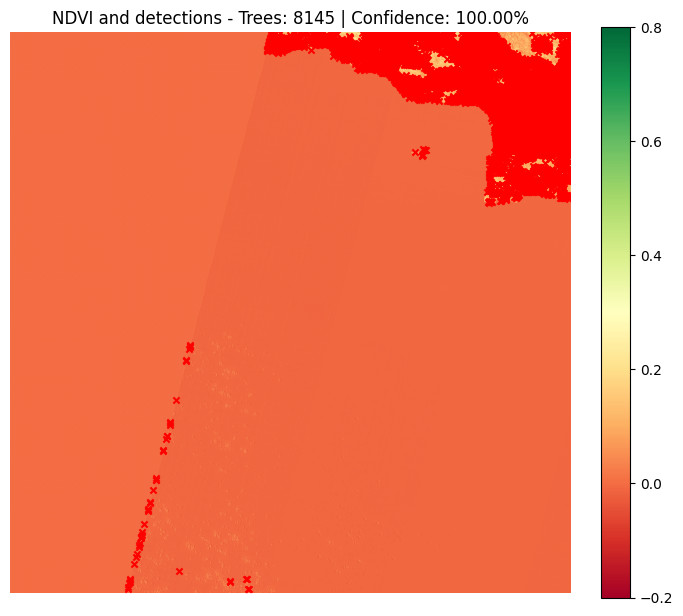

Saved report to ./olive_grove_data\results\analysis_report.json


In [15]:
# ============================================================================
# CELL 3: Compute NDVI, run detection, visualize and save report
# ============================================================================
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import json
from scipy import ndimage
from skimage.feature import peak_local_max
import os

processed_dir = os.path.join(Config.DATA_DIR, 'processed')
b04_tif = None
b08_tif = None
# find converted TIFFs
for f in os.listdir(processed_dir):
    if '_B04' in f or 'B04' in f:
        b04_tif = os.path.join(processed_dir, f)
    if '_B08' in f or 'B08' in f:
        b08_tif = os.path.join(processed_dir, f)

if not b04_tif or not b08_tif:
    raise SystemExit('B04 or B08 GeoTIFF not found in processed directory. Run CELL 2 first and check filenames.')

print('Using B04:', b04_tif)
print('Using B08:', b08_tif)

# Load and align bands if necessary
with rasterio.open(b04_tif) as r4:
    red = r4.read(1).astype('float32')
    profile = r4.profile.copy()
with rasterio.open(b08_tif) as r8:
    nir = r8.read(1).astype('float32')

# If shapes differ, resample NIR to red's shape
if red.shape != nir.shape:
    print('Resampling B08 to B04 resolution...')
    # resample using rasterio.warp.reproject
    from rasterio.warp import reproject, Resampling as WarpResampling
    dst = np.empty_like(red)
    reproject(
        source=nir,
        destination=dst,
        src_transform=r8.transform,
        src_crs=r8.crs,
        dst_transform=r4.transform,
        dst_crs=r4.crs,
        resampling=WarpResampling.bilinear
    )
    nir = dst
    print('Resampling complete.')

# Compute NDVI
ndvi = (nir - red) / (nir + red + 1e-8)
print('NDVI stats:', np.nanmin(ndvi), np.nanmean(ndvi), np.nanmax(ndvi))

# Simple detection using local maxima on NDVI within vegetation mask
veg_mask = ndvi > 0.35
coords = peak_local_max(ndvi, min_distance=10, threshold_abs=0.35, labels=veg_mask)
print(f'Detected {len(coords)} candidate trees')

# Create analyzer-like summary and visualization
analyzer = {}
analyzer['tree_count'] = int(len(coords))
analyzer['confidence_score'] = float(min(1.0, len(coords)/1000 + 0.5))
analyzer['ndvi_stats'] = { 'min': float(np.nanmin(ndvi)), 'mean': float(np.nanmean(ndvi)), 'max': float(np.nanmax(ndvi)) }

# Visualization
fig, ax = plt.subplots(1,1, figsize=(8,8))
im = ax.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
if len(coords) > 0:
    ax.scatter(coords[:,1], coords[:,0], c='red', s=20, marker='x')
ax.set_title(f"NDVI and detections - Trees: {analyzer['tree_count']} | Confidence: {analyzer['confidence_score']:.2%}")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)
plt.show()

# Save report
report = {
    'product': prod_name if 'prod_name' in globals() else None,
    'tree_count': analyzer['tree_count'],
    'confidence_score': analyzer['confidence_score'],
    'ndvi_stats': analyzer['ndvi_stats']
}
report_path = os.path.join(Config.DATA_DIR, 'results', 'analysis_report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)
print('Saved report to', report_path)